In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import nengo

# Hannas Test Net - Nengo

In [8]:
net = nengo.Network()

In [ ]:
with net:
    node1 = nengo.Node(output=0.5) # use output for input layer, poisson spike function with frequency = pixel intensity
    neurons = []
    for n in range(5):
        neurons.append(nengo.Ensemble(1,2))

# SNN Architecture Null Model

c:\Users\hanna\Downloads\NMC-Project-Code\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


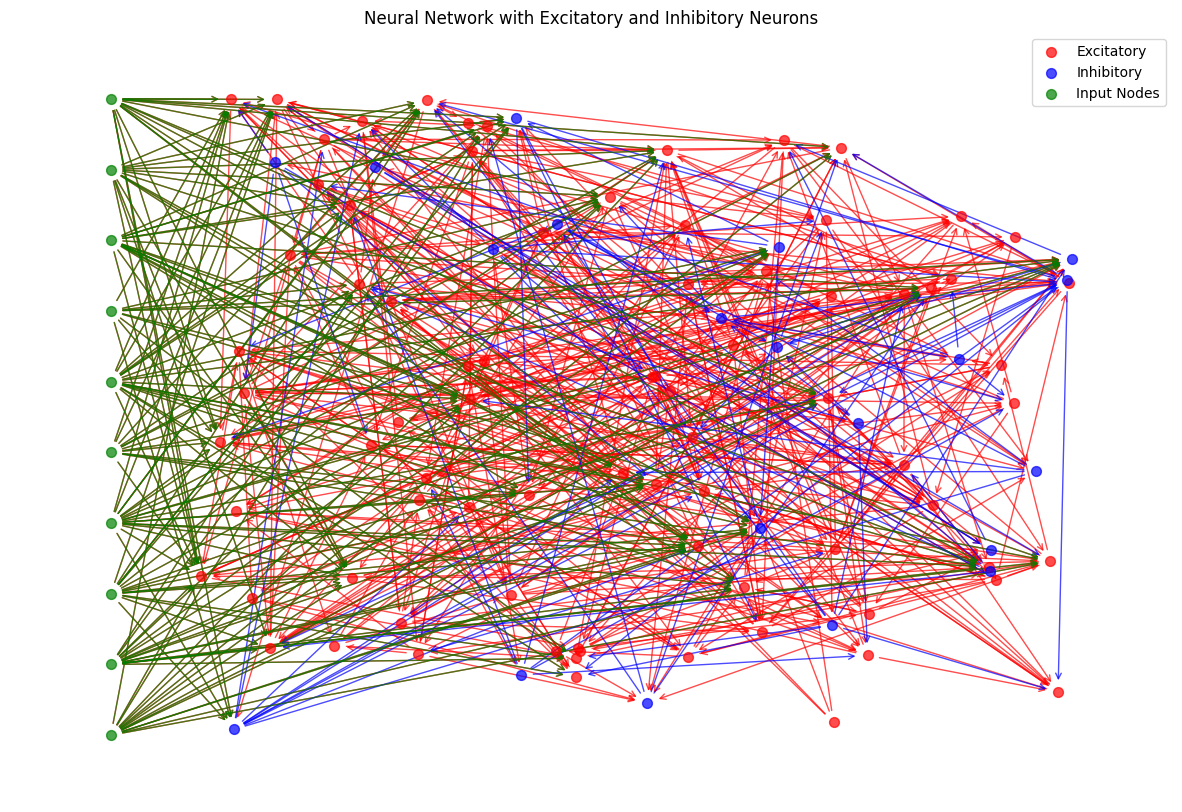

In [23]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def generate_neural_network(num_neurons, excitatory_ratio=0.8, connection_prob=0.1):
    """
    Generates a neural network with excitatory and inhibitory neurons.

    Args:
        num_neurons (int): Total number of neurons.
        excitatory_ratio (float): Proportion of excitatory neurons (default: 0.8, for 4:1 ratio).
        connection_prob (float): Probability of connection between any two neurons.
    
    Returns:
        G (nx.DiGraph): Directed graph representing the network.
    """
    # Number of excitatory and inhibitory neurons
    num_excitatory = int(num_neurons * excitatory_ratio)
    num_inhibitory = num_neurons - num_excitatory

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes with attributes (excitatory or inhibitory)
    for i in range(num_neurons):
        if i < num_excitatory:
            G.add_node(i, type="excitatory")
        else:
            G.add_node(i, type="inhibitory")

    # Add edges with weights, respecting Dale's principle
    for i in range(num_neurons):
        for j in range(num_neurons):
            if i != j and np.random.rand() < connection_prob:
                if G.nodes[i]["type"] == "excitatory":
                    weight = np.random.uniform(0.1, 1.0)  # Positive weight
                else:
                    weight = np.random.uniform(-1.0, -0.1)  # Negative weight
                G.add_edge(i, j, weight=weight)
    
    return G

def add_input_layer(G, num_input_nodes=10, subset_size=30, input_prob=0.5):
    """
    Adds an input layer to the neural network.

    Args:
        G (nx.DiGraph): Existing neural network graph.
        num_input_nodes (int): Number of input nodes to add.
        subset_size (int): Size of the subset of existing neurons to connect to.
        input_prob (float): Probability of connection from input nodes to subset neurons.

    Returns:
        G (nx.DiGraph): Updated graph with input layer.
    """
    num_existing_neurons = len(G.nodes)
    input_layer_start = num_existing_neurons

    # Add input nodes
    for i in range(num_input_nodes):
        G.add_node(input_layer_start + i, type="input")

    # Randomly select a subset of existing neurons
    subset_neurons = np.random.choice(num_existing_neurons, subset_size, replace=False)

    # Add edges from input nodes to subset neurons with the given probability
    for input_node in range(input_layer_start, input_layer_start + num_input_nodes):
        for target_neuron in subset_neurons:
            if np.random.rand() < input_prob:
                weight = np.random.uniform(0.1, 1.0)  # Positive weight for input connections
                G.add_edge(input_node, target_neuron, weight=weight)

    return G

def plot_network(G):
    """
    Plots the network, color-coding excitatory and inhibitory neurons.

    Args:
        G (nx.DiGraph): Directed graph representing the network.
    """
    pos = nx.random_layout(G)  # Layout for visualization
    excitatory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "excitatory"]
    inhibitory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "inhibitory"]
    input_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "input"]
    
    num_input_nodes = len(input_nodes)
    for i, node in enumerate(input_nodes):
        pos[node] = (-0.1, i / (num_input_nodes - 1) if num_input_nodes > 1 else 0.5)

    plt.figure(figsize=(15,10))
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=excitatory_nodes, node_color="red", label="Excitatory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=inhibitory_nodes, node_color="blue", label="Inhibitory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_color="green", label="Input Nodes", alpha=0.7, node_size=50)

    # Draw edges
    weights = nx.get_edge_attributes(G, "weight")
    excitatory_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] > 0]
    inhibitory_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] < 0]
    input_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == "input"]

    nx.draw_networkx_edges(G, pos, edgelist=excitatory_edges, edge_color="red", arrowstyle="->", arrowsize=10, alpha=0.7, label="Excitatory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=inhibitory_edges, edge_color="blue", arrowstyle="->", arrowsize=10, alpha=0.7, label="Inhibitory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=input_edges, edge_color="green", arrowstyle="->", arrowsize=10, alpha=0.7, label="Input Connections")


    # Add legend
    plt.legend()
    plt.title("Neural Network with Excitatory and Inhibitory Neurons")
    plt.axis("off")
    plt.show()

# Parameters
num_neurons = 100  # Total number of neurons
excitatory_ratio = 0.8  # 4:1 ratio (80% excitatory)
connection_prob = 0.05  # 10% connection probability

# Generate and plot network
G = generate_neural_network(num_neurons, excitatory_ratio, connection_prob)
G = add_input_layer(G, num_input_nodes=10, subset_size=30, input_prob=0.5)
plot_network(G)